In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns

from lifetimes.utils import summary_data_from_transaction_data

# Custom modules

import sys
import os
ROOT_DIR = os.path.abspath('../')
sys.path.insert(0, ROOT_DIR + "/src")

# Constants

In [2]:
RAW_INPUT_PATH = '../data/raw/bs140513_032310.csv'
IGNORE_COLS = ['zipcodeOri', 'zipMerchant']

# Load input

In [3]:
raw_df = pd.read_csv(RAW_INPUT_PATH,
                     quotechar="'",
                     usecols=lambda c: c not in IGNORE_COLS)

# Methodology

#TODO: Describe 2 approaches in CLV modeling (ML and Probabilistics)

Below I approach this problem using Probabilistic methods namely BG/NBD model and Gamma-Gamma, with implementation based on [Python lifetimes package](https://lifetimes.readthedocs.io/en/latest/Quickstart.html#estimating-customer-lifetime-value-using-the-gamma-gamma-model).

The paper for BG/NBD can be found [here](http://www.brucehardie.com/papers/bgnbd_2004-04-20.pdf).

Outlines:
1. Create a baseline


# Baseline

Assumption: a user will behave exactly the same in the next `n` days compared to recent `n` days.

Long-term value of a user in the next 30 days = Long-term value of a user in recent 30 days

In [205]:
n = 30
max_step = raw_df['step'].max()
cutoff_step = max_step - n
start_step = cutoff_step - n

In [206]:
y_pred_base = (raw_df.query(f"step > {start_step} and step <= {cutoff_step}")
                     .groupby('customer')['amount'].sum())

In [240]:
y_true = (raw_df.query(f"step > {cutoff_step}")
                .groupby('customer')['amount'].sum())

In [254]:
y_df = pd.merge(y_true.to_frame('y_holdout'),
                y_pred_base.to_frame('y_pred_base'),
                how='outer',
                left_index=True,
                right_index=True) \
         .fillna(0)

In [267]:
mae_base = metrics.mean_absolute_error(y_df['y_holdout'],
                                       y_df['y_pred_base'])

# Calculate features

## Using utils function from lifetime

#### Convert step to pseudo date for easier implementation

In [13]:
cnt_steps = raw_df['step'].nunique()
pseudo_date_mapper = pd.Series(index=list(range(cnt_steps)),
                               data=pd.date_range("2020-01-01",
                                                  periods=cnt_steps))
raw_df['pseudo_date'] = raw_df['step'].map(pseudo_date_mapper)

In [20]:
raw_df['pseudo_date']

0        2020-01-01
1        2020-01-01
2        2020-01-01
3        2020-01-01
4        2020-01-01
            ...    
594638   2020-06-28
594639   2020-06-28
594640   2020-06-28
594641   2020-06-28
594642   2020-06-28
Name: pseudo_date, Length: 594643, dtype: datetime64[ns]

---

In [21]:
summary_df = summary_data_from_transaction_data(raw_df,
                                                customer_id_col='customer',
                                                datetime_col='pseudo_date',
                                                monetary_value_col='amount')

In [22]:
summary_df

,frequency,recency,T,monetary_value
customer,,,,
C1000148617,127.0,149.0,149.0,35.064331
C100045114,90.0,179.0,179.0,109.016889
C1000699316,92.0,173.0,179.0,38.677174
C1001065306,20.0,134.0,158.0,305.277000
C1002658784,127.0,157.0,157.0,33.778583
...,...,...,...,...
C99729647,168.0,178.0,179.0,33.738452
C998690782,167.0,179.0,179.0,62.397066
C998987490,169.0,179.0,179.0,33.607337


# Analyze Frequency/Recency

In [31]:
data = summary_df.copy()

In [29]:
from lifetimes import BetaGeoFitter

In [184]:
# penalizer_coef=0 yields convergence error
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(data['frequency'], data['recency'], data['T'])
bgf

<lifetimes.BetaGeoFitter: fitted with 4112 subjects, a: 0.00, alpha: 4.24, b: 0.40, r: 3.34>

In [89]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,3.343352,0.060667,3.224444,3.462260
alpha,4.236400,0.085112,4.069581,4.403219
a,0.001129,0.000222,0.000693,0.001564
b,0.401115,0.071826,0.260336,0.541893


#### Visualize F/R Matrix

In [44]:
from lifetimes.plotting import plot_frequency_recency_matrix

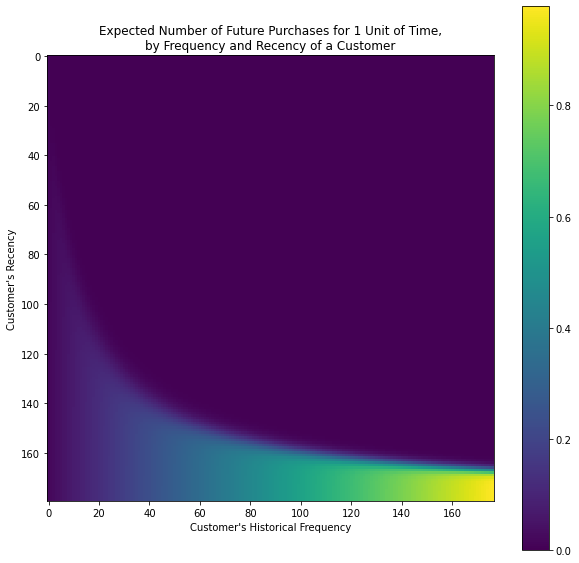

In [46]:
plt.figure(figsize=(10,10))
plot_frequency_recency_matrix(bgf)

In [47]:
from lifetimes.plotting import plot_probability_alive_matrix

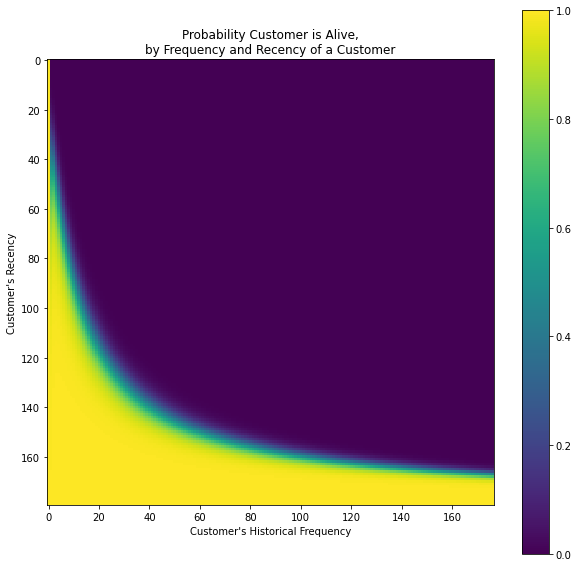

In [48]:
plt.figure(figsize=(10,10))
plot_probability_alive_matrix(bgf)

#### Ranking customers from best to worst by probability of purchasing

In [63]:
t = 1
fn_pred_expected_purchases = bgf.conditional_expected_number_of_purchases_up_to_time
ppt_name = f'predicted_purchases_{t}'
data[ppt_name] = fn_pred_expected_purchases(t,
                                            data['frequency'],
                                            data['recency'],
                                            data['T'])
data.sort_values(by=ppt_name).tail(5)

,frequency,recency,T,monetary_value,predicted_purchases,predicted_value_1,predicted_purchases_1
customer,,,,,,,
C1882101149,176.0,179.0,179.0,33.980057,356.978488,33.257797,0.978745
C1999699557,176.0,179.0,179.0,34.455170,356.978488,33.722811,0.978745
C1155962240,176.0,179.0,179.0,34.845852,356.978488,34.105189,0.978745
C333484923,176.0,179.0,179.0,32.946818,356.978488,32.246520,0.978745
C222098023,176.0,179.0,179.0,31.382443,356.978488,30.715396,0.978745


To estimate the expected value in $, we can use multiply the `monetary_value` with `predicted_purchases` as monetary_value is [equal to the sum of all a customer’s purchases divided by the total number of purchases](https://lifetimes.readthedocs.io/en/latest/Quickstart.html#example-using-transactional-datasets).

In [55]:
pvt_name = f'predicted_value_{t}'
data[pvt_name] = (data['predicted_purchases']
                  * data['monetary_value'])

In [56]:
data.sort_values([pvt_name], ascending=False)

,frequency,recency,T,monetary_value,predicted_purchases,predicted_value_1
customer,,,,,,
C806399525,134.0,148.0,148.0,624.571418,9.021605e-01,5.634637e+02
C2004941826,89.0,165.0,168.0,724.821910,5.361066e-01,3.885818e+02
C1849046345,107.0,167.0,167.0,563.231402,6.443829e-01,3.629367e+02
C1350963410,118.0,167.0,167.0,474.251949,7.086214e-01,3.360651e+02
C1572610482,70.0,171.0,177.0,829.179143,4.046043e-01,3.354894e+02
...,...,...,...,...,...,...
C1816212551,127.0,143.0,179.0,39.156929,3.304653e-08,1.294001e-06
C1945950459,97.0,116.0,155.0,36.575876,3.079402e-08,1.126318e-06
C537330939,56.0,112.0,179.0,25.314286,2.957809e-08,7.487482e-07


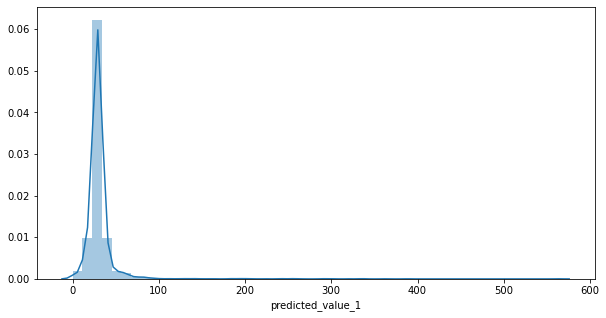

In [59]:
plt.figure(figsize=(10,5))
sns.distplot(data[pvt_name])

- The distribution is right-skewed, with expected values lie in range (20, 30).

#### Long-term values

The following calculations are based on assumptions:
1. \# of purchases in K days = P(purchase|1 day) * \# days
2. Average spending of customer does not change in the next K days period

In [61]:
long_term_periods = 365

In [64]:
t = long_term_periods
fn_pred_expected_purchases = bgf.conditional_expected_number_of_purchases_up_to_time
ppt_name = f'predicted_purchases_{t}'
data[ppt_name] = fn_pred_expected_purchases(t,
                                            data['frequency'],
                                            data['recency'],
                                            data['T'])
data.sort_values(by=ppt_name).tail(5)

,frequency,recency,T,monetary_value,predicted_purchases,predicted_value_1,predicted_purchases_1,predicted_purchases_365
customer,,,,,,,,
C1882101149,176.0,179.0,179.0,33.980057,356.978488,33.257797,0.978745,356.978488
C1999699557,176.0,179.0,179.0,34.455170,356.978488,33.722811,0.978745,356.978488
C1155962240,176.0,179.0,179.0,34.845852,356.978488,34.105189,0.978745,356.978488
C333484923,176.0,179.0,179.0,32.946818,356.978488,32.246520,0.978745,356.978488
C222098023,176.0,179.0,179.0,31.382443,356.978488,30.715396,0.978745,356.978488


In [65]:
pvt_name = f'predicted_value_{t}'
data[pvt_name] = (data['predicted_purchases']
                  * data['monetary_value'])

In [66]:
data.sort_values([pvt_name], ascending=False)

,frequency,recency,T,monetary_value,predicted_purchases,predicted_value_1,predicted_purchases_1,predicted_purchases_365,predicted_value_365
customer,,,,,,,,,
C806399525,134.0,148.0,148.0,624.571418,3.290122e+02,5.634637e+02,9.021605e-01,3.290122e+02,205491.615515
C2004941826,89.0,165.0,168.0,724.821910,1.955262e+02,3.885818e+02,5.361066e-01,1.955262e+02,141721.702295
C1849046345,107.0,167.0,167.0,563.231402,2.350164e+02,3.629367e+02,6.443829e-01,2.350164e+02,132368.632705
C1350963410,118.0,167.0,167.0,474.251949,2.584457e+02,3.360651e+02,7.086214e-01,2.584457e+02,122568.355520
C1572610482,70.0,171.0,177.0,829.179143,1.475684e+02,3.354894e+02,4.046043e-01,1.475684e+02,122360.654106
...,...,...,...,...,...,...,...,...,...
C1816212551,127.0,143.0,179.0,39.156929,1.205304e-05,1.294001e-06,3.304653e-08,1.205304e-05,0.000472
C1945950459,97.0,116.0,155.0,36.575876,1.123059e-05,1.126318e-06,3.079402e-08,1.123059e-05,0.000411
C537330939,56.0,112.0,179.0,25.314286,1.078779e-05,7.487482e-07,2.957809e-08,1.078779e-05,0.000273


# Assessing model fit

## Period transactions

In [68]:
from lifetimes.plotting import plot_period_transactions

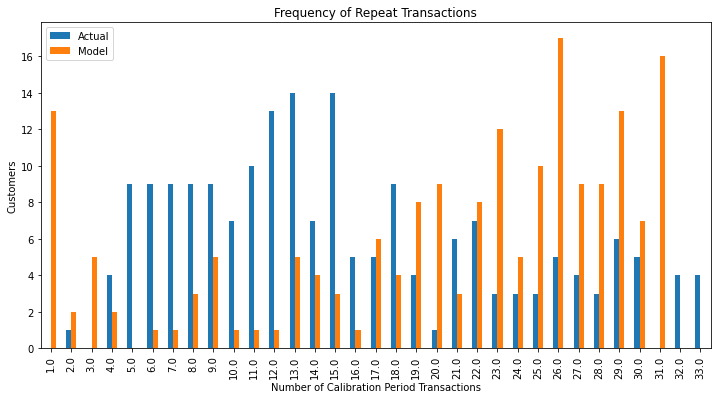

In [93]:
plot_period_transactions(bgf, max_frequency=30, figsize=(12,6))

## Calibrate and hold out data

In [97]:
from lifetimes.utils import calibration_and_holdout_data

In [227]:
summary_cal_holdout = calibration_and_holdout_data(
    raw_df, 'customer', 'pseudo_date',
    monetary_value_col='amount',
    calibration_period_end='2020-05-29',
    observation_period_end='2020-06-28' )

In [228]:
summary_cal_holdout

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer,,,,,,,
C1000148617,101.0,117.0,119.0,32.093069,26.0,43.277500,30.0
C100045114,61.0,149.0,149.0,143.750328,29.0,31.598485,30.0
C1000699316,90.0,141.0,149.0,35.648000,2.0,116.660000,30.0
C1001065306,18.0,123.0,128.0,311.356111,2.0,250.565000,30.0
C1002658784,100.0,127.0,127.0,32.962100,27.0,36.802593,30.0
...,...,...,...,...,...,...,...
C99729647,140.0,149.0,149.0,29.624929,28.0,50.685667,30.0
C998690782,139.0,149.0,149.0,69.194101,28.0,26.744333,30.0
C998987490,142.0,149.0,149.0,28.083451,27.0,54.573871,30.0


In [99]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

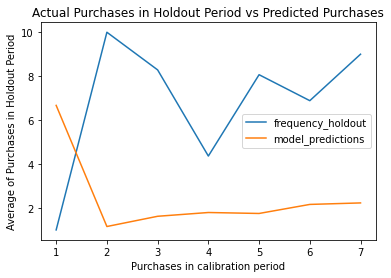

In [229]:
bgf.fit(summary_cal_holdout['frequency_cal'],
        summary_cal_holdout['recency_cal'],
        summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf,
                                                summary_cal_holdout)

# Compare to baseline

In [230]:
long_term_periods = 30

In [231]:
t = long_term_periods
fn_pred_expected_purchases = bgf.conditional_expected_number_of_purchases_up_to_time
ppt_name = f'predicted_purchases_{t}'
summary_cal_holdout[ppt_name] = fn_pred_expected_purchases(
    t,
    summary_cal_holdout['frequency_cal'],
    summary_cal_holdout['recency_cal'],
    summary_cal_holdout['T_cal'])
summary_cal_holdout.sort_values(by=ppt_name).tail(5)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,predicted_purchases_30
customer,,,,,,,,
C369046885,146.0,149.0,149.0,32.659452,29.0,31.046364,30.0,29.235200
C1155962240,147.0,149.0,149.0,32.920136,29.0,43.120333,30.0,29.431421
C1698085181,147.0,149.0,149.0,31.735918,27.0,31.842857,30.0,29.431421
C220904895,147.0,149.0,149.0,32.800544,26.0,22.560385,30.0,29.431421
C333484923,148.0,149.0,149.0,31.455676,28.0,39.420690,30.0,29.627642


In [232]:
pvt_name = f'predicted_value_{t}'
summary_cal_holdout[pvt_name] = (summary_cal_holdout[ppt_name]
                                 * summary_cal_holdout['monetary_value_cal'])

In [233]:
summary_cal_holdout.sort_values([pvt_name], ascending=False)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,predicted_purchases_30,predicted_value_30
customer,,,,,,,,,
C806399525,106.0,118.0,118.0,746.732358,28.0,108.070000,30.0,2.682559e+01,2.003154e+04
C1849046345,81.0,137.0,137.0,710.681852,26.0,84.391563,30.0,1.788457e+01,1.271024e+04
C1572610482,66.0,147.0,147.0,872.977879,4.0,106.500000,30.0,1.371696e+01,1.197460e+04
C2004941826,74.0,138.0,138.0,728.775270,15.0,480.899091,30.0,1.627850e+01,1.186336e+04
C1350963410,90.0,137.0,137.0,563.016222,28.0,110.213958,30.0,1.980098e+01,1.114827e+04
...,...,...,...,...,...,...,...,...,...
C1607207670,86.0,106.0,149.0,36.902907,13.0,41.823571,30.0,1.832931e-07,6.764049e-06
C1683902488,56.0,88.0,149.0,38.226071,5.0,142.190000,30.0,4.129732e-08,1.578634e-06
C1058785965,50.0,82.0,149.0,46.876400,3.0,115.852500,30.0,1.959130e-08,9.183695e-07


In [234]:
y_pred_bgf = summary_cal_holdout[pvt_name]

In [264]:
y_df = y_df.join(y_pred_bgf).rename(columns={'predicted_value_30': 'y_pred_bgf'})

In [268]:
mae_bgf = metrics.mean_absolute_error(y_df['y_holdout'],
                                      y_df['y_pred_bgf'])

In [269]:
delta = 1 - mae_bgf / mae_base

In [272]:
print(f"BGF model outperforms baseline by {delta:,.0%}")

BGF model outperforms baseline by 8%


# Tune

In [115]:
from hyperopt import fmin, tpe, hp, anneal, Trials

In [116]:
from sklearn import metrics

In [126]:
def get_results(summary, model, kind, n):
    duration_holdout = summary.iloc[0]["duration_holdout"]

    summary["model_predictions"] = model.conditional_expected_number_of_purchases_up_to_time(
            duration_holdout, summary["frequency_cal"], summary["recency_cal"], summary["T_cal"])

    results = (summary.groupby(kind)
                      [["frequency_holdout", "model_predictions"]]
                      .mean().iloc[:n])
    return results

def tune(params, summary, n, random_state):
    params = {'penalizer_coef': float(params['penalizer_coef'])}
    kind = 'frequency_cal'
    
    model = BetaGeoFitter(**params)
    model.fit(summary['frequency_cal'],
              summary['recency_cal'],
              summary['T_cal'])
    
    results = get_results(summary, model, kind, n)
    y_true = results['model_predictions']
    y_pred = results['frequency_holdout']
    
    score = np.sqrt(metrics.mean_squared_error(y_true, y_pred))

    return score

In [131]:
from functools import partial

In [169]:
params = {'penalizer_coef': hp.uniform("penalizer_coef",
                                       0.001, 0.1)}
n = 30
# n_iter = 2
timeout = 60
random_state = 42

fn_tune = partial(tune, summary=summary_cal_holdout.copy(), n=30,
                  random_state=random_state)

trials = Trials()

best=fmin(fn=fn_tune, # function to optimize
          space=params,
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
#           max_evals=n_iter, # maximum number of iterations
          timeout=timeout,
          trials=trials, # logging
          rstate=np.random.RandomState(random_state), # fixing random state for the reproducibility
          catch_eval_exceptions=True
         )

      fun: -430.94568428226347                                                                                   
 hess_inv: array([[ 9.81821988e-01,  1.03351894e+00, -2.13315387e-01,
         7.43477554e-02],
       [ 1.03351894e+00,  1.70632976e+00, -1.53251658e-01,
         1.10293689e-01],
       [-2.13315387e-01, -1.53251658e-01,  1.64539009e+02,
         6.02513459e+01],
       [ 7.43477554e-02,  1.10293689e-01,  6.02513459e+01,
         9.46953604e+01]])
      jac: array([-1.08561038e-07, -1.02851572e-07, -1.44036746e-08,  4.53243258e-09])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 74
      nit: 34
     njev: 62
   status: 2
  success: False
        x: array([ 0.41239379, -4.34197555, -7.21006653, -1.78457023])
  0%|          | 5/9223372036854775807 [00:02<946534124314274:42:08,  2.71trial/s, best loss: 11.790038967385277]

job exception: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.




      fun: -431.0129615726557                                                                                     
 hess_inv: array([[ 1.05802148e+00,  1.06048710e+00,  3.68679953e-01,
        -8.63824040e-02],
       [ 1.06048710e+00,  1.58993811e+00,  9.23233676e-01,
        -9.66926975e-02],
       [ 3.68679953e-01,  9.23233676e-01,  1.52353886e+02,
         5.63059182e+01],
       [-8.63824040e-02, -9.66926975e-02,  5.63059182e+01,
         9.80997243e+01]])
      jac: array([ 1.01472815e-07, -1.62422761e-07,  1.39613341e-09,  4.03372065e-09])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 82
      nit: 33
     njev: 70
   status: 2
  success: False
        x: array([ 0.55532839, -4.19907973, -7.09944786, -1.6173834 ])
  0%|          | 7/9223372036854775807 [00:03<1226910326143246:13:20,  2.09trial/s, best loss: 11.790038967385277]

job exception: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.




      fun: -431.1576157481337                                                                                     
 hess_inv: array([[  1.19938899,   1.24831711,   0.93135867,   0.24355573],
       [  1.24831711,   1.65910399,   0.76638572,   0.33278391],
       [  0.93135867,   0.76638572, 138.54428799,  53.22407693],
       [  0.24355573,   0.33278391,  53.22407693, 110.07203271]])
      jac: array([ 2.49924263e-07, -3.12182539e-07, -2.04814236e-08, -1.03715872e-09])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 87
      nit: 35
     njev: 75
   status: 2
  success: False
        x: array([ 0.89408355, -3.86044188, -6.83910152, -1.18679355])
  0%|          | 22/9223372036854775807 [00:09<931761066131821:05:04,  2.75trial/s, best loss: 11.53015407727109]

job exception: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.




      fun: -431.34989071137466                                                                                    
 hess_inv: array([[ 1.90398998e+00,  1.89486044e+00,  3.67115695e-01,
         1.50808653e-02],
       [ 1.89486044e+00,  2.11966182e+00,  2.91266004e-01,
        -1.01848006e-01],
       [ 3.67115695e-01,  2.91266004e-01,  1.37484309e+02,
         5.79927107e+01],
       [ 1.50808653e-02, -1.01848006e-01,  5.79927107e+01,
         1.60420645e+02]])
      jac: array([-4.60274514e-07,  4.35057378e-07, -1.05915746e-08, -3.81942007e-09])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 88
      nit: 37
     njev: 76
   status: 2
  success: False
        x: array([ 1.47739756, -3.27745009, -6.25185012,  0.10205749])
  0%|          | 25/9223372036854775807 [00:11<1160306951259035:26:56,  2.21trial/s, best loss: 11.53015407727109]

job exception: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.




      fun: -431.2490281623029                                                                                     
 hess_inv: array([[ 1.42597502e+00,  1.46062547e+00,  2.64060622e-02,
         7.41462026e-02],
       [ 1.46062547e+00,  1.79105718e+00,  2.34859368e-01,
        -1.13507376e-01],
       [ 2.64060622e-02,  2.34859368e-01,  1.44010653e+02,
         5.31313531e+01],
       [ 7.41462026e-02, -1.13507376e-01,  5.31313531e+01,
         1.21239355e+02]])
      jac: array([ 1.26468085e-07, -1.56001826e-07, -2.52035994e-09, -1.56027356e-09])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 76
      nit: 35
     njev: 64
   status: 2
  success: False
        x: array([ 1.14241065, -3.61222976, -6.63683523, -0.80549944])
  0%|          | 32/9223372036854775807 [00:14<1092753033952782:04:48,  2.34trial/s, best loss: 11.53015407727109]

job exception: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.




      fun: -431.27882147556767                                                                                    
 hess_inv: array([[ 1.50247399e+00,  1.49141882e+00,  7.09783416e-03,
         4.03154426e-01],
       [ 1.49141882e+00,  1.75407888e+00, -3.73959710e-01,
         5.96712793e-01],
       [ 7.09783416e-03, -3.73959710e-01,  1.41496145e+02,
         5.53704245e+01],
       [ 4.03154426e-01,  5.96712793e-01,  5.53704245e+01,
         1.28446128e+02]])
      jac: array([-6.42161247e-08,  1.24790223e-07,  2.22210896e-12,  1.14856039e-09])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 80
      nit: 37
     njev: 69
   status: 2
  success: False
        x: array([ 1.23259592, -3.52209338, -6.55571934, -0.63677552])
  0%|          | 35/9223372036854775807 [00:16<1183463003569940:37:20,  2.16trial/s, best loss: 11.53015407727109]

job exception: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.




      fun: -431.2712933318509                                                                                     
 hess_inv: array([[1.45018028e+00, 1.41071195e+00, 4.31690670e-01, 3.14197696e-02],
       [1.41071195e+00, 1.62942871e+00, 1.75190694e-01, 1.15964674e-01],
       [4.31690670e-01, 1.75190694e-01, 1.45257067e+02, 5.39506794e+01],
       [3.14197696e-02, 1.15964674e-01, 5.39506794e+01, 1.28204816e+02]])
      jac: array([-1.86341541e-07,  2.65660629e-07, -1.40558292e-08,  1.80839472e-08])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 98
      nit: 36
     njev: 86
   status: 2
  success: False
        x: array([ 1.20925468, -3.54542151, -6.57737791, -0.68286027])
  0%|          | 35/9223372036854775807 [00:17<1183463003569940:37:20,  2.16trial/s, best loss: 11.53015407727109]

job exception: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.




      fun: -431.3466912842264                                                                                     
 hess_inv: array([[  1.66884999,   1.73249813,   1.23436181,  -1.11177147],
       [  1.73249813,   1.98310551,   1.02583052,  -1.50904729],
       [  1.23436181,   1.02583052, 136.59626687,  59.5104577 ],
       [ -1.11177147,  -1.50904729,  59.5104577 , 144.8654025 ]])
      jac: array([-5.33674793e-07,  2.41388869e-07,  1.65491974e-09,  8.32794088e-10])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 91
      nit: 35
     njev: 79
   status: 2
  success: False
        x: array([ 1.46525606, -3.28958243, -6.27471435,  0.04030883])
  0%|          | 41/9223372036854775807 [00:20<1138824876792442:10:08,  2.25trial/s, best loss: 11.53015407727109]

job exception: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.




      fun: -431.12828666110414                                                                                    
 hess_inv: array([[1.11128766e+00, 1.16320437e+00, 9.35073967e-01, 8.98406855e-03],
       [1.16320437e+00, 1.61693316e+00, 1.11542451e+00, 1.85868223e-01],
       [9.35073967e-01, 1.11542451e+00, 1.48482033e+02, 5.70094155e+01],
       [8.98406855e-03, 1.85868223e-01, 5.70094155e+01, 1.06716445e+02]])
      jac: array([ 2.32796819e-07, -2.09005290e-07, -1.76410535e-08,  4.95863857e-09])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 68
      nit: 35
     njev: 57
   status: 2
  success: False
        x: array([ 0.82106106, -3.93343556, -6.8957681 , -1.28550729])
  0%|          | 42/9223372036854775807 [00:20<1577769096824513:59:28,  1.62trial/s, best loss: 11.53015407727109]

job exception: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.




      fun: -431.2697787433565                                                                                     
 hess_inv: array([[1.45717234e+00, 1.42121873e+00, 4.59673930e-01, 5.78014252e-02],
       [1.42121873e+00, 1.64195803e+00, 2.37820657e-01, 1.39686605e-01],
       [4.59673930e-01, 2.37820657e-01, 1.45787395e+02, 5.37841171e+01],
       [5.78014252e-02, 1.39686605e-01, 5.37841171e+01, 1.28185650e+02]])
      jac: array([-1.08828132e-07,  1.64449348e-07, -1.01647732e-08,  1.28372069e-08])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 79
      nit: 36
     njev: 67
   status: 2
  success: False
        x: array([ 1.2046063 , -3.55006734, -6.58162801, -0.69181389])
  0%|          | 43/9223372036854775807 [00:21<1791333151714714:44:16,  1.43trial/s, best loss: 11.53015407727109]

job exception: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.




      fun: -430.9358976798421                                                                                     
 hess_inv: array([[9.94266532e-01, 1.03513428e+00, 4.21234751e-01, 8.08885299e-02],
       [1.03513428e+00, 1.69407528e+00, 5.67654117e-01, 8.04847427e-02],
       [4.21234751e-01, 5.67654117e-01, 1.74234336e+02, 6.14410273e+01],
       [8.08885299e-02, 8.04847427e-02, 6.14410273e+01, 9.43099198e+01]])
      jac: array([-8.17222130e-08, -1.54676836e-07, -1.23048378e-08,  1.60211360e-09])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 40
      nit: 35
     njev: 40
   status: 2
  success: False
        x: array([ 0.39220138, -4.36216295, -7.22585845, -1.80777058])
  0%|          | 55/9223372036854775807 [00:26<1012048398373105:29:36,  2.53trial/s, best loss: 11.53015407727109]

job exception: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.




      fun: -431.180950986821                                                                                      
 hess_inv: array([[  1.20878614,   1.24514858,   0.84731302,   0.15477997],
       [  1.24514858,   1.63765454,   1.06731167,   0.26909854],
       [  0.84731302,   1.06731167, 150.16481841,  54.58659688],
       [  0.15477997,   0.26909854,  54.58659688, 112.65101584]])
      jac: array([ 7.04650178e-08, -1.48606681e-07, -8.39710613e-09, -1.67653839e-09])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 92
      nit: 36
     njev: 81
   status: 2
  success: False
        x: array([ 0.95419931, -3.8003514 , -6.79180969, -1.10195515])
  0%|          | 57/9223372036854775807 [00:28<1148955512912237:39:12,  2.23trial/s, best loss: 11.53015407727109]

job exception: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.




      fun: -431.16201754601974                                                                                    
 hess_inv: array([[ 1.14471639e+00,  1.17240588e+00,  5.28316391e-01,
        -9.22943215e-02],
       [ 1.17240588e+00,  1.57638144e+00,  9.27837155e-01,
         7.26169284e-02],
       [ 5.28316391e-01,  9.27837155e-01,  1.55777135e+02,
         5.63536054e+01],
       [-9.22943215e-02,  7.26169284e-02,  5.63536054e+01,
         1.10181854e+02]])
      jac: array([ 1.99972935e-07, -2.58499795e-07, -1.67815418e-08, -1.24156581e-09])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 41
      nit: 36
     njev: 41
   status: 2
  success: False
        x: array([ 0.90527873, -3.84925129, -6.83034547, -1.17126114])
  0%|          | 71/9223372036854775807 [00:33<967985923012833:08:16,  2.65trial/s, best loss: 11.524353781533256]

job exception: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.




      fun: -431.2937051830075                                                                                      
 hess_inv: array([[1.59391280e+00, 1.59630038e+00, 5.37147215e-01, 8.58617547e-02],
       [1.59630038e+00, 1.87954315e+00, 2.36213824e-01, 1.31353111e-01],
       [5.37147215e-01, 2.36213824e-01, 1.33914924e+02, 5.64442776e+01],
       [8.58617547e-02, 1.31353111e-01, 5.64442776e+01, 1.34291202e+02]])
      jac: array([-1.38376492e-07,  1.31905036e-07, -1.49895186e-09,  8.34055459e-10])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 92
      nit: 38
     njev: 77
   status: 2
  success: False
        x: array([ 1.2799843 , -3.47473243, -6.50983224, -0.53645562])
  0%|          | 74/9223372036854775807 [00:35<1072833866485618:54:56,  2.39trial/s, best loss: 11.524353781533256]

job exception: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.




      fun: -431.08198359098907                                                                                     
 hess_inv: array([[1.08094771e+00, 1.11792724e+00, 5.06881204e-01, 1.92732954e-02],
       [1.11792724e+00, 1.60861308e+00, 7.87712430e-01, 7.27527128e-02],
       [5.06881204e-01, 7.87712430e-01, 1.64186736e+02, 5.87896260e+01],
       [1.92732954e-02, 7.27527128e-02, 5.87896260e+01, 1.03106092e+02]])
      jac: array([ 6.76523684e-08, -1.95401985e-07, -1.55358475e-08,  2.16860595e-09])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 43
      nit: 35
     njev: 43
   status: 2
  success: False
        x: array([ 0.71069209, -4.04376488, -6.98049912, -1.42766835])
  0%|          | 79/9223372036854775807 [00:37<1070691171559808:59:44,  2.39trial/s, best loss: 11.524353781533256]

job exception: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.




      fun: -431.18306952419715                                                                                     
 hess_inv: array([[  1.2753819 ,   1.31092492,   0.62537695,   0.29006327],
       [  1.31092492,   1.68887805,   0.47115958,   0.31361493],
       [  0.62537695,   0.47115958, 139.05374137,  51.30556573],
       [  0.29006327,   0.31361493,  51.30556573, 112.55783248]])
      jac: array([ 6.96348225e-08, -1.70548718e-07, -9.38135521e-09, -2.03148724e-09])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 73
      nit: 35
     njev: 62
   status: 2
  success: False
        x: array([ 0.95975421, -3.79479893, -6.78740235, -1.09392691])
  0%|          | 94/9223372036854775807 [00:44<957874044998902:45:20,  2.67trial/s, best loss: 11.523773782551258]

job exception: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.




      fun: -430.99744542361105                                                                                     
 hess_inv: array([[ 1.03541290e+00,  1.06079332e+00,  1.26458478e-01,
        -1.55277338e-01],
       [ 1.06079332e+00,  1.63735565e+00, -3.34600784e-01,
        -2.15883239e-01],
       [ 1.26458478e-01, -3.34600784e-01,  1.56053306e+02,
         5.99166449e+01],
       [-1.55277338e-01, -2.15883239e-01,  5.99166449e+01,
         9.82467581e+01]])
      jac: array([-1.75591934e-07,  5.27375803e-08,  5.69860748e-09,  3.20725020e-09])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 70
      nit: 33
     njev: 59
   status: 2
  success: False
        x: array([ 0.52168552, -4.23271286, -7.12532912, -1.65726048])
  0%|          | 96/9223372036854775807 [00:45<1416732171807926:36:48,  1.81trial/s, best loss: 11.523773782551258]

job exception: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.




      fun: -431.24853331978994                                                                                     
 hess_inv: array([[ 1.42942812e+00,  1.46572488e+00,  8.47708914e-03,
         9.91439529e-02],
       [ 1.46572488e+00,  1.79954703e+00,  1.61315026e-01,
        -1.11570895e-01],
       [ 8.47708914e-03,  1.61315026e-01,  1.42801885e+02,
         5.30905184e+01],
       [ 9.91439529e-02, -1.11570895e-01,  5.30905184e+01,
         1.20849361e+02]])
      jac: array([ 1.07799241e-07, -1.36332035e-07, -2.60195997e-09, -1.51657820e-09])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 87
      nit: 35
     njev: 76
   status: 2
  success: False
        x: array([ 1.14095944, -3.61368021, -6.63809117, -0.80803137])
  0%|          | 99/9223372036854775807 [00:47<1294878978375577:18:56,  1.98trial/s, best loss: 11.523773782551258]

job exception: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.




      fun: -431.14477158396744                                                                                      
 hess_inv: array([[  1.1698868 ,   1.22383193,   0.96721912,   0.17407347],
       [  1.22383193,   1.65229625,   0.8525751 ,   0.30417648],
       [  0.96721912,   0.8525751 , 139.92983977,  54.55221814],
       [  0.17407347,   0.30417648,  54.55221814, 108.6915623 ]])
      jac: array([ 2.91218795e-07, -3.23793135e-07, -2.26128921e-08,  1.70987786e-09])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 69
      nit: 35
     njev: 57
   status: 2
  success: False
        x: array([ 0.86177796, -3.89273449, -6.86425756, -1.23099557])
  0%|          | 111/9223372036854775807 [00:52<954590883351980:39:28,  2.68trial/s, best loss: 11.523773782551258]

job exception: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.




      fun: -431.049671179634                                                                                        
 hess_inv: array([[  0.97526886,   0.9615261 ,   0.73150023,   0.28464359],
       [  0.9615261 ,   1.46346939,   0.73611899,   0.41793919],
       [  0.73150023,   0.73611899, 155.63315216,  56.55777865],
       [  0.28464359,   0.41793919,  56.55777865, 100.93482747]])
      jac: array([-2.47771342e-07,  1.04484004e-09, -1.87173163e-08,  4.15873501e-08])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 91
      nit: 33
     njev: 79
   status: 2
  success: False
        x: array([ 0.63672768, -4.11770499, -7.03706714, -1.51924809])
  0%|          | 114/9223372036854775807 [00:53<1122162049605910:45:20,  2.28trial/s, best loss: 11.523773782551258]

job exception: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.




      fun: -431.28681109681065                                                                                      
 hess_inv: array([[ 1.51624407e+00,  1.49818894e+00, -7.56423677e-02,
         2.40942484e-01],
       [ 1.49818894e+00,  1.74847480e+00, -5.30575043e-01,
         4.03204044e-01],
       [-7.56423677e-02, -5.30575043e-01,  1.38776978e+02,
         5.55976954e+01],
       [ 2.40942484e-01,  4.03204044e-01,  5.55976954e+01,
         1.31074269e+02]])
      jac: array([-1.97697375e-07,  2.83781925e-07, -8.75917877e-10,  2.19440171e-09])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 81
      nit: 37
     njev: 70
   status: 2
  success: False
        x: array([ 1.25782039, -3.49688331, -6.53165073, -0.58461898])
  0%|          | 114/9223372036854775807 [00:54<1122162049605910:45:20,  2.28trial/s, best loss: 11.523773782551258]

job exception: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.




      fun: -431.34693675559                                                                                         
 hess_inv: array([[ 1.93628698e+00,  1.90026235e+00, -2.26680486e-02,
         8.64957066e-03],
       [ 1.90026235e+00,  2.07438395e+00, -8.25431993e-02,
        -4.37705740e-01],
       [-2.26680486e-02, -8.25431993e-02,  1.36833759e+02,
         6.00224751e+01],
       [ 8.64957066e-03, -4.37705740e-01,  6.00224751e+01,
         1.45198258e+02]])
      jac: array([-1.39468358e-07,  9.30305949e-08,  2.48790256e-09, -1.92073992e-09])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 104
      nit: 37
     njev: 90
   status: 2
  success: False
        x: array([ 1.46618435, -3.28865487, -6.27303459,  0.0448128 ])
  0%|          | 121/9223372036854775807 [00:57<1012952048831723:31:12,  2.53trial/s, best loss: 11.523773782551258]

job exception: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.




  0%|          | 127/9223372036854775807 [01:00<1210726310260971:22:40,  2.12trial/s, best loss: 11.52174000324797] 


#### Visualize

In [170]:
tpe_results = np.array([[x['result']['loss'],
                         x['misc']['vals']['penalizer_coef'][0]] for x in trials.trials])

tpe_results_df = pd.DataFrame(tpe_results,
                              columns=['score', 'penalizer_coef'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f961e5d8a00>,
      dtype=object)

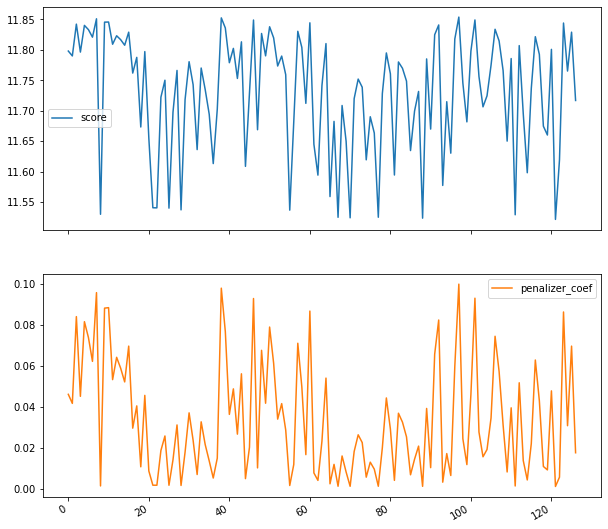

In [171]:
tpe_results_df.plot(subplots=True,figsize=(10, 10))

# Gamma-Gamma

In [173]:
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

In [178]:
summary_df

,frequency,recency,T,monetary_value
customer,,,,
C1000148617,127.0,149.0,149.0,35.064331
C100045114,90.0,179.0,179.0,109.016889
C1000699316,92.0,173.0,179.0,38.677174
C1001065306,20.0,134.0,158.0,305.277000
C1002658784,127.0,157.0,157.0,33.778583
...,...,...,...,...
C99729647,168.0,178.0,179.0,33.738452
C998690782,167.0,179.0,179.0,62.397066
C998987490,169.0,179.0,179.0,33.607337


In [180]:
returning_customers_summary = (summary_df[summary_df['frequency']>0])

In [181]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,-0.531216
frequency,-0.531216,1.000000


[According to lifetimes docs](https://lifetimes.readthedocs.io/en/latest/Quickstart.html#example-using-transactional-datasets):
>The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

Our data has `monetary_value` and `frequency` are moderately negatively correlated, so we should not use Gamma-Gamma approach.

# Conclusion

## Summary

In this notebook, I approach the Customer Long-term Values problem by Probabilistic Model. Compared to a simple baseline of predicting next transaction

## Next steps

# Archive

#### Using util function from `lifetimes`

In [182]:
from lifetimes.utils import expected_cumulative_transactions

In [186]:
expected_cumulative_transactions(model=bgf,
                                 transactions=raw_df,
                                 datetime_col='pseudo_date',
                                 customer_id_col='customer',
                                 t=30)

,actual,predicted
0,0,1898.276528
1,2071,4058.745613
2,4355,6329.281579
3,6719,8676.521223
4,9108,11095.255750
5,11507,13574.627025
6,13949,16121.064853
7,16373,18718.084138
8,18838,21361.815170
9,21361,24052.311553
